In [255]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1, l2
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping


In [226]:
df = pd.read_csv("./dataset_fixeds.csv")
df['timeStamps'] = pd.to_datetime(df['timeStamps'])
df.set_index('timeStamps', inplace=True)
df

,bufferSizes,bufferingStates,bufferingEvents,newBitrates,oldBitrates,resolutions,streamBandwidths,estimatedBandwidths
timeStamps,,,,,,,,
2024-09-16 06:11:10.683000+00:00,1.0,1,0.047000,14998609,5019963,3840p,1.4,3.1
2024-09-16 06:11:11.739000+00:00,1.0,0,0.047000,14998609,5019963,3840p,1.4,7.1
2024-09-16 06:11:12.812000+00:00,1.0,0,0.047000,14998609,5019963,3840p,1.4,7.1
2024-09-16 06:11:13.867000+00:00,1.0,0,0.047000,14998609,5019963,3840p,1.4,7.1
2024-09-16 06:11:14.927000+00:00,1.0,0,0.047000,14998609,5019963,3840p,1.4,7.1
...,...,...,...,...,...,...,...,...
2024-09-16 06:26:48.759000+00:00,1.0,0,309.145001,1321829,826869,640p,1.2,1.7
2024-09-16 06:26:49.824000+00:00,0.9,0,309.145001,1321829,826869,640p,1.2,1.7
2024-09-16 06:26:51.951000+00:00,1.0,1,310.029001,1321829,826869,640p,1.2,1.9


In [227]:
features = df[['oldBitrates', 'streamBandwidths','estimatedBandwidths',"bufferingStates","bufferSizes"]]
target = df['newBitrates']  # Target prediksi

In [228]:
# Scaling semua fitur ke range 0-1
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)

# Scaling target juga
scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Membagi data jadi training dan testing (70% training, 30% testing)
train_features, test_features, train_target, test_target = train_test_split(
    features_scaled, target_scaled, test_size=0.2, shuffle=False)

# Fungsi untuk membuat sequences (LSTM butuh data urutan)
def create_sequences(data, target, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = target[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Buat sequence dengan panjang 10 (misalnya)
sequence_length = 10
X_train, y_train = create_sequences(train_features, train_target, sequence_length)
X_test, y_test = create_sequences(test_features, test_target, sequence_length)

# Cek shape data hasil preprocessing
print(X_train.shape, y_train.shape) 
# Hasilnya harus dalam bentuk (samples, timesteps, features)

(460, 10, 5) (460, 1)


In [273]:
model = Sequential()


# model.add(GRU(units=8, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=l2(0.002)))
# model.add(Dropout(0.2))
# model.add(GRU(units=8, return_sequences=True,kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.1))
# model.add(GRU(units=8, return_sequences=False))

# Best units for Layer 1: 16
# Best number of GRU layers: 1
# Best dropout for Layer 1: 0.4
# Best learning rate: 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.add(GRU(units=8,activation="relu", return_sequences=True,   
              input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=l2(0.002)))
model.add(Dropout(0.4))
model.add(GRU(units=8 ,activation="relu",return_sequences=False,kernel_regularizer=l2(0.002)))
model.add(Dropout(0.1))
# model.add(GRU(units=16, activation="relu", kernel_regularizer=l2(0.001),return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.4))
model.add(Dense(1,activation="relu"))
model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=[keras.metrics.Accuracy()] )
model.summary()

d:\cursor_code\python\Lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_17 (GRU)                    │ (None, 10, 8)          │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_18 (GRU)                    │ (None, 8)              │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

In [274]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10,batch_size=4, callbacks=[early_stopping],validation_split=0.2, verbose=1,validation_data=(X_test, y_test))

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0000e+00 - loss: 0.1422 - val_accuracy: 0.0000e+00 - val_loss: 0.0455
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0995 - val_accuracy: 0.0000e+00 - val_loss: 0.0495
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.1091 - val_accuracy: 0.0000e+00 - val_loss: 0.0561
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0889 - val_accuracy: 0.0000e+00 - val_loss: 0.0616
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0797 - val_accuracy: 0.0000e+00 - val_loss: 0.0646
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0852 - val_accuracy: 0.0000e+00 - val_loss: 0.0643


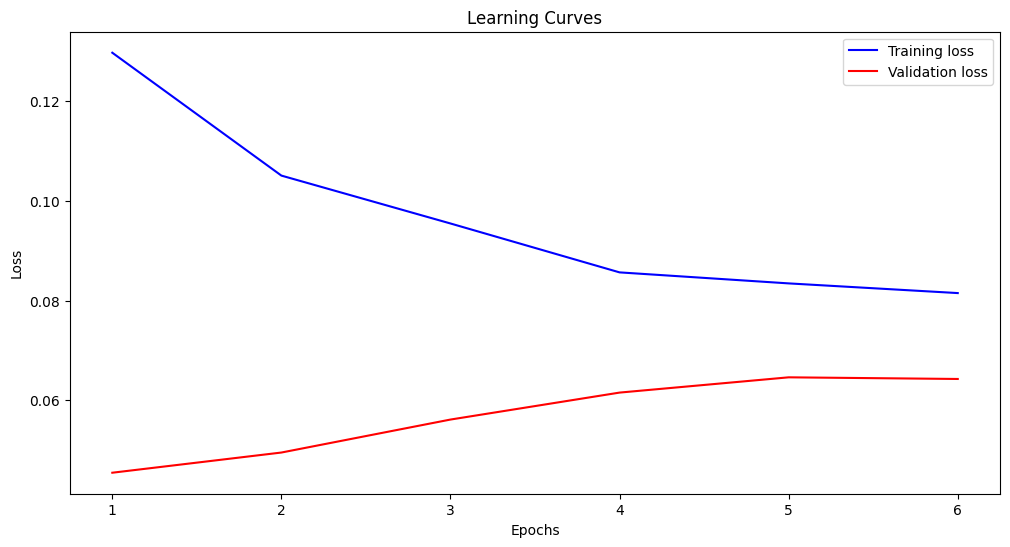

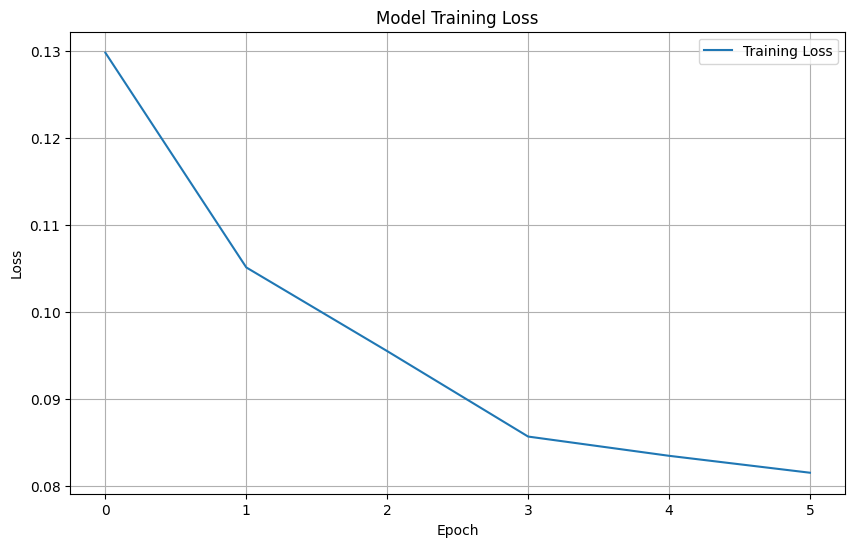

In [275]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.grid(True)
plt.show()


In [276]:
predictions = model.predict(X_test)

# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label='Actual')
# plt.plot(predictions, label='Predicted')
# plt.legend()
# plt.show()
print("predictions", predictions.shape)
print("y_test",y_test.shape)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
predictions (108, 1)
y_test (108, 1)


In [277]:
predictions_last = predictions[:, -1, 0]  # Bentuk jadi (108,)

# Cek bentuknya
print(predictions_last.shape)  # Output: (108,)s


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

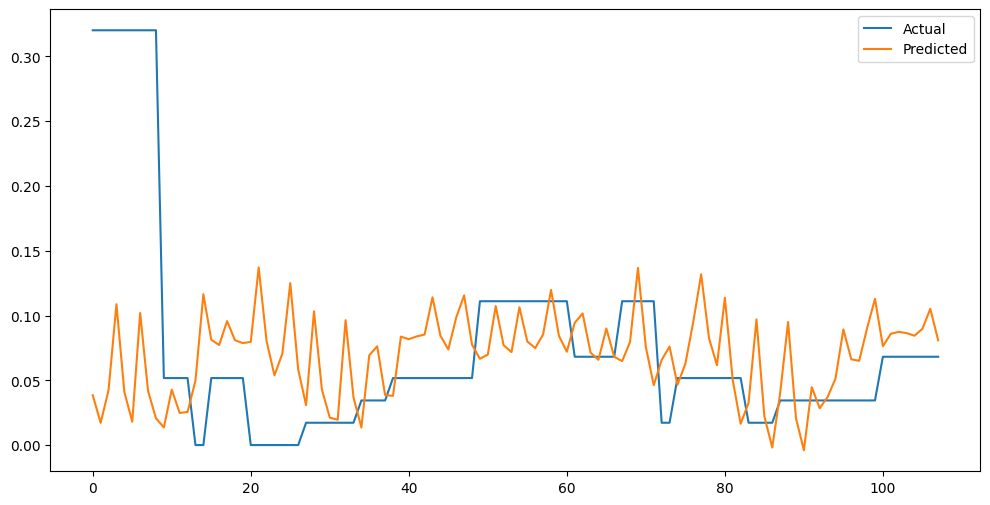

In [278]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions_last, label='Predicted')
plt.legend()
plt.show()

In [279]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

r2 = r2_score(y_test, predictions_last)
r2



-0.2383856232190973

In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
def build_model(hp):
    model = Sequential()
    
    # Tambah beberapa layer GRU (misalnya antara 1-3 layer)
    for i in range(hp.Int('num_layers', 1, 3)):  # Nyoba antara 1-3 layer GRU
        # Units di tiap layer GRU (misalnya antara 16 sampai 128)
        units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
        
        # Tambahin GRU layer (return_sequences buat multi-layer)
        if i == 0:
            model.add(GRU(units, input_shape=(10, 5), return_sequences=(i < hp.get('num_layers') - 1)))
        else:
            model.add(GRU(units, return_sequences=(i < hp.get('num_layers') - 1)))
        
        # Dropout layer buat regularisasi (misalnya antara 0.0 sampai 0.5)
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))
    
    # Layer output untuk binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Pilih learning rate dari beberapa opsi (1e-2, 1e-3, 1e-4)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile model dengan optimizer Adam
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
X_train = np.random.rand(460, 10, 5)  # 460 sampel, 10 timestep, 5 fitur
y_train = np.random.rand(460, 1)  # 460 target, binary classification

In [ ]:
# Setup RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimisasi berdasarkan validation accuracy
    max_trials=5,  # Coba 5 kombinasi hyperparameter yang berbeda
    executions_per_trial=3,  # Eksekusi tiap kombinasi hyperparameter 3 kali buat kestabilan hasil
    directory='my_dir',  # Folder untuk menyimpan hasil tuning
    project_name='gru_tuning'  # Nama project tuning
)

# Mulai tuning dengan X_train dan y_train
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)


In [ ]:
# Ambil kombinasi hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print hyperparameter terbaik
print(f"Best units for Layer 1: {best_hps.get('units_0')}")
if best_hps.get('num_layers') > 1:
    print(f"Best units for Layer 2: {best_hps.get('units_1')}")
print(f"Best number of GRU layers: {best_hps.get('num_layers')}")
print(f"Best dropout for Layer 1: {best_hps.get('dropout_0')}")
if best_hps.get('num_layers') > 1:
    print(f"Best dropout for Layer 2: {best_hps.get('dropout_1')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Build model terbaik dengan hyperparameter yang terpilih
best_model = tuner.hypermodel.build(best_hps)

# Train model terbaik
best_model.fit(X_train, y_train, epochs=10, validation_split=0.2)
